In [20]:
#https://plotly.com/python/reference/

default_title = 'Animated Map - County Spread Rate'

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : 'white'}

import io
import json
import os
import pandas as pd
import mpu
import numpy as np
import random
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from geojson_utils import centroid
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image, clear_output, Video
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from PIL import Image as PILImage
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from scipy.signal import find_peaks, peak_prominences
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
directory = 'C:\\Users\\izdr\\source\\repos\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\'

!git -C $directory pull

state_names = pd.read_csv('Data\\states.csv').set_index('State').to_dict()['Abbreviation']
bgcolor = '#0d1238'

excluded_ny_counties = [36047, # Kings County (Brooklyn)
    36005, # Bronx County (Bronx)
    36085, # Richmond County (Staten Island)
    36081] # Queens County (Queens)

voter_data_filename = 'Data\\countypres_2000-2016.csv'

location_of_census_data = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/'



Already up to date.


In [21]:
def get_census_info():
    result = (
        pd.read_csv("Data\\co-est2019-alldata.csv", encoding = "ISO-8859-1") # Fetch the file
        .query('SUMLEV == 50')                                         # 40 is states, 50 is counties
        [['STATE', 'COUNTY', 'CTYNAME', 'POPESTIMATE2019', 'STNAME']]            # Keep Just population estimate
        .assign(fips=lambda x: (x['STATE'] * 1000) + x['COUNTY'])      # FIPS = stateId*1000+countyId                                # 
        .rename(columns={'POPESTIMATE2019':'pop', 'CTYNAME':'county', 'STNAME': 'st'})                     # Shorten Population Estimate column
        [['fips', 'pop']]                                              # Keep just FIPS and PopEstimate
        .set_index('fips')                                             # Index by FIPS
    )
    return sum_ny_under_manhattan(result, 'pop')

def get_county_names():
    return (
        pd.read_csv("Data\\co-est2019-alldata.csv", encoding = "ISO-8859-1") # Fetch the file
        .query('SUMLEV == 50 & COUNTY % 2 == 1')                                         # 40 is states, 50 is counties
        [['STATE', 'COUNTY', 'CTYNAME', 'POPESTIMATE2019', 'STNAME']]            # Keep Just population estimate
        .assign(fips=lambda x: (x['STATE'] * 1000) + x['COUNTY'])      # FIPS = stateId*1000+countyId                                # 
        .rename(columns={'POPESTIMATE2019':'pop', 'CTYNAME':'county', 'STNAME': 'st'})                     # Shorten Population Estimate column
        [['fips', 'st', 'county']]                                              # Keep just FIPS and PopEstimate
        .set_index('fips')                                             # Index by FIPS
    )

def get_daily_report_data():
    states = list(state_names.keys())                                 # List of 51 states (including DC)
    print(directory)
    return (
        pd.concat([ \
            pd.read_csv(directory+file) \
            .assign(date=datetime.strptime(file, '%m-%d-%Y.csv')) \
            for file \
            in os.listdir(directory) \
            if file.endswith(".csv") \
        ])                                                            # List the files, appending a date column to each file's data
        .reset_index()                                                # Reset the index
        .query('FIPS.notna()')                                        # Pick only items with FIPS values
        .assign(FIPS=lambda x:x['FIPS'].astype(int))                  # And cast that FIPS value to integer
        .query('Province_State.isin(@states)')                        # Only the states
    )

def get_county_percentages():
    daily_report_data = get_daily_report_data()
    
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
        .fillna(0)                                                # Fill NA values here.
    )
    
    # Here we're going to ensure cumulative confirmed values are always increasing. 
    # We'll do this by comparing the existing values against the cumulative maximum 
    # for that time series, removing the numbers that don't conform to this, and then 
    # interpolating those missing values. For an example of a time series that does 
    # this, look at the Brazoria County values (48049), between June 8 and 9. The 
    # cumulative maximum drops from 990 to 770, which, since we're creating a differential
    # here, would inject a massive negative value into our rolling average. This clearly
    # isn't the way it's supposed to be, because when you look at the data between
    # June 15 and June 16, the values jump again from 864 to 1495. We'll smooth those
    # values out here, in the absence of any accessible SME who can tell us what 
    # happened, and in the interest of time. 
    daily_report_data = (
        starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
        .interpolate()                       # Interpolate the "actual" values for those items.
        .diff()                              # _Now_ we get our dialy differential. 
        .rolling(window=7)                   # Roll this value 7 days for smoothness. 
        .mean()                              # Take the mean of the rolling window. 
        .dropna()                            # Drop the first 6 rows, an artifact of rolling.
        .T                                   # Transpose the whole DataFrame
    )

    # Grab the county populations
    county_populations = get_census_info()
    
    # Divide the values of new confirmed cases by the county population,
    # and then multiply by 100,000 to get the "per 100,000" people metric.
    return (daily_report_data.div(county_populations.iloc[:,0], axis=0).dropna()) * 100000

def sum_ny_under_manhattan(frame, field):
    df = frame.copy()
    # New York is a special case. All the data is aggregated under Manhattan. 
    manhattan = 36061 # New York County (Manhattan) -- INCLUDED

    # EXCLUDED
    excluded_ny_counties = [36047, # Kings County (Brooklyn)
    36005, # Bronx County (Bronx)
    36085, # Richmond County (Staten Island)
    36081] # Queens County (Queens)

    nyc_population = df.loc[excluded_ny_counties + [manhattan]].sum().sum()

    df.loc[manhattan, field] = nyc_population

    #county_populations.index.isin(excluded_ny_counties)
    return df[~df.index.isin(excluded_ny_counties)]

def get_new_cases_info_raw(daily_report_data=None):
    if (daily_report_data is None):
        daily_report_data=get_daily_report_data()
        
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
        .fillna(0)                                                # Fill NA values here.
    )
    
    return starter

def get_new_cases_info(daily_report_data=None):
    starter = get_new_cases_info_raw(daily_report_data)

    rep_a = (
        starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
        .interpolate()                       # Interpolate the "actual" values for those items.
        .rolling(window=7)                   # Roll this value 7 days for smoothness. 
        .mean()                              # Take the mean of the rolling window. 
        .dropna()                            # Drop the first 6 rows, an artifact of rolling.
        .T                                   # Transpose the whole DataFrame
    )

    return (rep_a.sum().diff().dropna())

def get_land_mass_data():
    counties = get_allcounties()
    land_mass_data = [[int(x['properties']['STATE']) * 1000 + int(x['properties']['COUNTY']), x['properties']['CENSUSAREA']] for x in counties['features']]
    land_mass = pd.DataFrame(land_mass_data, columns=['fips', 'area']).set_index('fips')
    land_mass = sum_ny_under_manhattan(land_mass, 'area')
    land_mass['pop'] = get_census_info()
    land_mass = land_mass.dropna()
    land_mass['density'] = land_mass['pop'].div(land_mass['area'])
    return land_mass

def get_allcounties():
    # Get the GEOJson file for the counties.
    with open(os.getcwd() + '/Data/geojson-counties-fips.json') as response:
        allcounties = json.load(response)
    return allcounties

def get_centroid(geo):
    fips = int(geo['properties']['STATE'] + geo['properties']['COUNTY'])
    coords = geo['geometry']

    if (coords['type'] == 'MultiPolygon'):
        return [fips] + np.mean([o for ol in [item for sublist in coords['coordinates'] for item in sublist] for o in ol], axis=0).tolist()
        
    return [fips] + centroid(coords)['coordinates']


def get_centroids():
    counties = get_allcounties()
    centroids = [get_centroid(x) for x in counties['features']]
    return pd.DataFrame(centroids, columns=['fips', 'longitude', 'latitude']).dropna().assign(fips=lambda x:x['fips'].astype(int)).set_index('fips')

def get_conservatism():
    return (
        pd.read_csv(voter_data_filename)
        .query('year == 2016 & FIPS.notna() & party.isin(["democrat", "republican"])')
        .assign(
            fips=lambda x:x['FIPS'].astype(int),
            d=lambda x:(x['party'] == 'democrat').astype(int) * x['candidatevotes'], 
            r=lambda x:(x['party'] == 'republican').astype(int) * x['candidatevotes'])
        .groupby('fips')
        .sum()
        [['d', 'r']]
        .query('d != r')
        .assign(
            p_winner=lambda x:x.idxmax(axis=1),
            total=lambda x:x['d'] + x['r'],
            conservative=lambda x:x['r'] / x['total']
        )[['conservative']]
    )

def get_mean_ages():
    return (
        pd.read_csv("Data/cc-est2019-alldata.csv", encoding = "ISO-8859-1")
        .dropna()
        .query('YEAR==12 & AGEGRP > 0')
        .assign(fips=lambda x:x['STATE'].astype(int)*1000+x['COUNTY'].astype(int))
        [['fips', 'AGEGRP', 'TOT_POP']]
        .assign(
            AGEGRP=lambda x:x['AGEGRP'] * 5 - 2.5, 
            SUMAGE=lambda x:x['AGEGRP'] * x['TOT_POP']
        )
        .groupby('fips')
        .sum()
        .assign(mean_age=lambda x:x['SUMAGE']/x['TOT_POP'])
        [['mean_age']]
    )

def download_census_data(fips_code):
    print(fips_code)
    file = 'cc-est2019-agesex-{0}.csv'.format(fips_code);
    url = '{0}{1}'.format(location_of_census_data, file)
    print(url)
    r = requests.get(url, allow_redirects=True)
    if (r.status_code != 200):
        raise 'Error!'
    write_location = './gitignore-census-data/'
    if (not os.path.exists(write_location)):
        os.mkdir(write_location)
    open(write_location + file, 'wb').write(r.content)
        
def get_all_census_data():
    county_demographics = pd.read_csv("Data/cc-est2019-alldata.csv", encoding = "ISO-8859-1")
    fips = county_demographics[['STATE', 'STNAME']].groupby(['STATE', 'STNAME']).sum().reset_index().set_index('STNAME').loc[list(state_names.keys())]['STATE'].apply(lambda x:str(x).zfill(2)).tolist()
    df = pd.DataFrame()
    for fips_code in fips:
        file = 'cc-est2019-agesex-{0}.csv'.format(fips_code);
        fullpath = './gitignore-census-data/' + file
        if (not os.path.exists(fullpath)):
            download_census_data(fips_code)
        df = pd.concat([df, pd.read_csv(fullpath, encoding = "ISO-8859-1")])
        
    return df

def get_median_ages():
    return (
        get_all_census_data()
        .query('YEAR == 12')
        .assign(
            fips=lambda x:(x['STATE'].astype(int) * 1000 + x['COUNTY'].astype(int)), 
            tots=lambda x:(x['UNDER5_TOT']).div(x['POPESTIMATE']),
            kids=lambda x:(x['AGE513_TOT']).div(x['POPESTIMATE']),
            teens=lambda x:(x['AGE1417_TOT']).div(x['POPESTIMATE'])
        )
        .rename(columns={'MEDIAN_AGE_TOT': 'median_age' })
        .set_index('fips')
        [['median_age', 'tots', 'kids', 'teens']]
    )

def get_demographic_data():
    county_demographics = pd.read_csv("Data/cc-est2019-alldata.csv", encoding = "ISO-8859-1")
    return (county_demographics
         .query('(YEAR == 12) & (AGEGRP == 0)')
         .assign(fips=lambda x:x['STATE'].astype(int) * 1000 + x['COUNTY'].astype(int))
         .set_index('fips')
         .assign(hispanic=lambda x:(x['H_MALE'] + x['H_FEMALE']).div(x['TOT_POP']))
         .assign(black=lambda x:(x['BA_MALE'] + x['BA_FEMALE']).div(x['TOT_POP']))
         .assign(asian=lambda x:(x['AA_MALE'] + x['AA_FEMALE']).div(x['TOT_POP']))
         .assign(white=lambda x:(x['WA_MALE'] + x['WA_FEMALE']).div(x['TOT_POP']))
    )[['hispanic', 'black', 'asian', 'white']]

def adjusted_density(ds, loc):
    row = ds.loc[loc][['latitude', 'longitude']].dropna()
    if (len(row) == 0):
        return ds.loc[loc].density
    latlong = ds[['latitude', 'longitude']].dropna()
    latlong = latlong[(abs(latlong['latitude'] - row['latitude']) < 2) & (abs(latlong['longitude'] - row['longitude']) < 2)]
    origin = (row['latitude'], row['longitude'])
    distances = latlong.apply(lambda x:mpu.haversine_distance(origin, (x['latitude'], x['longitude'])), axis=1)
    distances = 100 - distances[distances < 100]
    return (ds.loc[distances.index]['density'] * distances).sum() / distances.sum()
    
def get_median_income():
    return (
        pd.read_excel('Data/est18all.xls', header=3)
        .assign(fips=lambda x:x['State FIPS Code'] * 1000 + x['County FIPS Code'])
        .rename(columns={
            'Median Household Income': 'median_income',
            'Poverty Percent, All Ages': 'poverty_percent'
        })
        .query('fips % 2 == 1')
        .set_index('fips')
        .assign(
            median_income=lambda x:x['median_income'].astype(str).apply(lambda x:float(x) if x.replace('.', '').isnumeric() else np.nan).astype(float),
            poverty_percent=lambda x:x['poverty_percent'].astype(str).apply(lambda x:float(x) if x.replace('.', '').isnumeric() else np.nan).astype(float)

        )
        [['median_income', 'poverty_percent']]
    )

def get_risk_factors():
    return (
        pd.ExcelFile('Data/CHSI DataSet.xls')
        .parse(10)
        .assign(fips=lambda x:x['State_FIPS_Code'] * 1000 + x['County_FIPS_Code'])
        .query('fips % 2 == 1')
        .set_index('fips')
        .rename(columns={'Obesity':'obesity', 'Diabetes':'diabetes'})
        [['State_FIPS_Code', 'obesity', 'diabetes']]
        .assign(
            obesity=lambda x:x[x['obesity'] > 0]['obesity'],
            diabetes=lambda x:x[x['diabetes'] > 0]['diabetes']
        )
        .groupby('State_FIPS_Code')
        .apply(lambda x:x.fillna(x.mean()))
        .drop(columns=['State_FIPS_Code'])
        .reset_index()
        .drop(columns=['State_FIPS_Code'])
        .set_index('fips')
    )

def get_county_details():
    county_details = pd.concat([
        get_county_names(),
        get_land_mass_data(),
        get_centroids(),
        get_conservatism(),
        get_median_ages(),
        get_mean_ages(), 
        get_demographic_data(), 
        get_median_income(), 
        get_risk_factors()
    ], axis=1)
    county_details['adjusted_density'] = county_details.apply(lambda x:adjusted_density(county_details, x.name), axis=1)
    return county_details

def get_details_and_percentages():
    county_details_raw = get_county_details()
    county_percentages_raw = get_county_percentages()
    county_details = county_details_raw[county_details_raw.index.isin(county_percentages_raw.index)].copy()
    county_percentages = county_percentages_raw[county_percentages_raw.index.isin(county_details_raw.index)].copy()

    max_index = len(county_percentages.columns) - 10

    county_details = (
        county_details
        .assign(
            max_height=lambda x:county_percentages.max(axis=1),
            peak_info_raw=lambda x:x.index.to_series()
            .apply(lambda y:find_peaks(county_percentages.loc[y], height=10, distance=30)),
            peak_info=lambda x:x['peak_info_raw'].apply(lambda y:list(zip(y[0], y[1]['peak_heights'])))

            #
        )
        .assign(
            peak_info=lambda x:(x['peak_info'].apply(lambda y:list(filter(lambda z:(z[0] < max_index), y))))
        )
        .assign(
            peak_info=lambda z:z.index.to_series().apply(lambda i:list(filter(lambda x:x[1]>=county_percentages.loc[i][-10:].max(), z.loc[i]['peak_info']))), 
            peak_count=lambda x:x['peak_info'].apply(lambda y:len(y)),
            peak_date=lambda x:x[x['peak_count'] > 0]['peak_info'].apply(lambda x:county_percentages.columns[x[-1][0]])
        )
    )

    county_details['median_infection'] = county_percentages.median(axis=1)
    county_details['mean_infection'] = county_percentages.mean(axis=1)
    county_details['max_infection'] = county_percentages.max(axis=1)
    return (county_details, county_percentages)

# Fetching original data

In [22]:
#get_median_ages()
county_details_raw, county_percentages_raw = get_details_and_percentages()

C:\Users\izdr\source\repos\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports\


In [23]:
county_details_raw.loc[48039]

st                                                              Texas
county                                                Brazoria County
area                                                           1357.7
pop                                                            374264
density                                                        275.66
longitude                                                    -95.4458
latitude                                                      29.1884
conservative                                                 0.627557
median_age                                                       36.1
tots                                                        0.0671692
kids                                                         0.134672
teens                                                       0.0592576
mean_age                                                      36.8205
hispanic                                                     0.315689
black               

# Correlation Heatmap

,area,pop,density,longitude,latitude,conservative,median_age,tots,kids,teens,...,median_income,poverty_percent,obesity,diabetes,adjusted_density,max_height,peak_count,median_infection,mean_infection,max_infection
count,3136.000000,3.136000e+03,3136.000000,3136.000000,3136.000000,3107.000000,3138.000000,3138.000000,3138.000000,3138.000000,...,3069.000000,3069.000000,3064.000000,3064.000000,3136.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000
mean,1120.128576,1.046610e+05,227.750723,-92.260283,38.440815,0.667340,41.754302,0.057564,0.110986,0.050716,...,52669.496579,15.121310,24.119118,7.789315,228.246603,65.618865,1.259720,7.008808,11.801870,65.618865
std,3603.877894,3.581701e+05,948.084838,12.810235,5.288740,0.160570,5.408456,0.011163,0.018491,0.007723,...,13647.991517,6.052155,4.303952,2.614966,495.261631,78.396375,1.260889,5.766046,7.753101,78.396375
min,1.999000,8.600000e+01,0.035944,-165.821260,19.601235,0.043048,22.200000,0.000000,0.000000,0.000000,...,25385.000000,2.600000,4.200000,0.500000,0.035944,0.000000,0.000000,0.000000,0.000000,0.000000
25%,431.170750,1.090000e+04,16.559432,-98.218605,34.689867,0.577916,38.600000,0.050931,0.100073,0.046224,...,43717.000000,10.800000,22.000000,6.100000,30.547495,29.210158,0.000000,2.755494,6.434310,29.210158
50%,616.475500,2.567300e+04,44.837082,-90.401169,38.358738,0.700845,41.600000,0.057165,0.110985,0.050798,...,50554.000000,14.100000,24.600000,7.700000,81.658414,48.612865,1.000000,5.622543,10.480947,48.612865
75%,923.916000,6.770050e+04,118.177204,-83.454691,41.805300,0.786874,44.800000,0.063099,0.120415,0.054824,...,58693.000000,18.200000,26.100000,9.125000,207.422663,76.545962,2.000000,10.143854,15.552518,76.545962
max,145504.789000,1.003911e+07,27546.703542,-67.462330,69.311670,0.967532,68.100000,0.131706,0.215289,0.105114,...,140382.000000,48.400000,42.600000,20.800000,5998.565088,1648.351648,6.000000,45.520358,82.420926,1648.351648


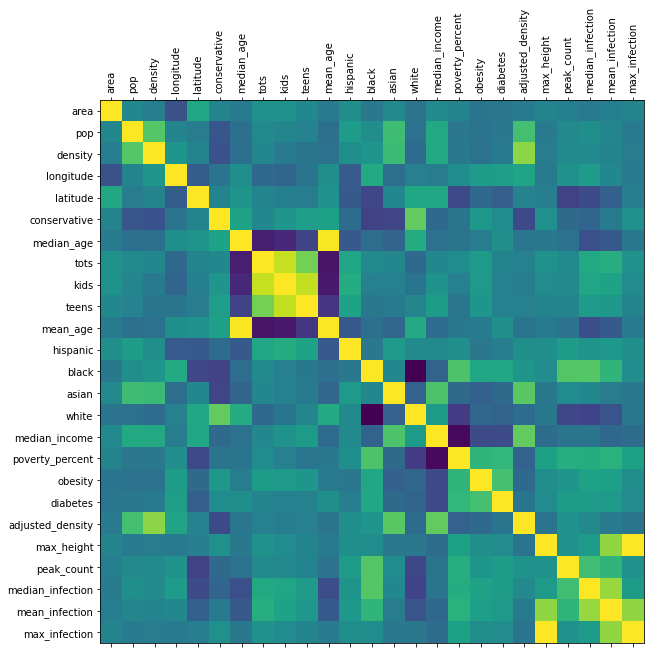

In [24]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols = county_details_raw.select_dtypes(include=numerics).columns;

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(county_details_raw.corr())
plt.xticks(range(len(cols)), cols, rotation='vertical');
plt.yticks(range(len(cols)), cols);
county_details_raw.describe()

In [25]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

county_details = county_details_raw.copy()
#whole_data = county_details.query('median_infection > 0')[]
x_columns = ['adjusted_density', 'longitude', 'latitude', 'conservative', 'median_age', 'white', 'hispanic', 'black', 'asian', 'median_income', 'poverty_percent', 'obesity', 'diabetes', 'tots', 'kids', 'teens']
y_columns = ['median_infection']

whole_data = county_details.query('mean_infection > 0')[x_columns + y_columns].dropna()
#print(county_details['median_infection'].min())
X = whole_data[x_columns].copy()
Y = whole_data[y_columns].copy()

# Group 2: Multiplying for clarity of interpretation
X['hispanic'] = X['hispanic'] * 100
X['black'] = X['black'] * 100
X['asian'] = X['asian'] * 100
X['white'] = X['white'] * 100
X['tots'] = X['tots'] * 100
X['teens'] = X['teens'] * 100
X['kids'] = X['kids'] * 100
X['conservative'] = X['conservative'] * 100


X_imputed = MinMaxScaler().fit_transform(X) * 100
X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print('R-Squared Adj: ' + str(model.rsquared_adj))
print(pd.DataFrame(model.params, columns=['risk_factor_coefficient']).sort_values(by='risk_factor_coefficient', ascending=False))

R-Squared Adj: 0.41843746259875025
                  risk_factor_coefficient
const                            9.797625
black                            0.109744
tots                             0.075758
teens                            0.041528
longitude                        0.027966
obesity                          0.021796
median_income                    0.009702
diabetes                         0.007274
hispanic                        -0.001859
asian                           -0.006072
kids                            -0.010050
poverty_percent                 -0.011163
white                           -0.015813
conservative                    -0.020346
adjusted_density                -0.049380
latitude                        -0.070933
median_age                      -0.095409


R-Squared Adj: 0.10587192710258153


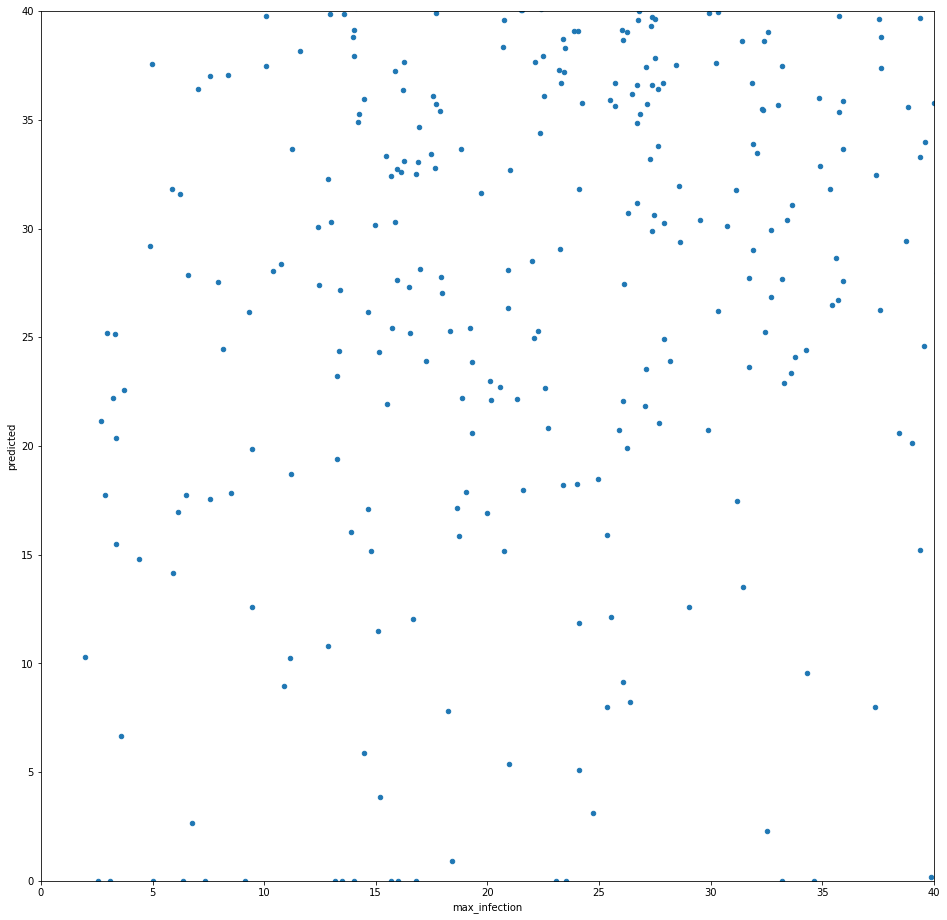

In [26]:
county_details = county_details_raw.copy()
#whole_data = county_details.query('median_infection > 0')[]
x_columns = ['adjusted_density', 'longitude', 'latitude', 'conservative', 'median_age', 'white', 'hispanic', 'black', 'asian', 'median_income', 'poverty_percent', 'obesity', 'diabetes', 'tots', 'kids', 'teens']
y_columns = ['max_infection']

whole_data = county_details.query('mean_infection > 0')[x_columns + y_columns].dropna()
#print(county_details['median_infection'].min())
X = whole_data[x_columns].copy()
Y = whole_data[y_columns].copy()

# Group 2: Multiplying for clarity of interpretation
X['hispanic'] = X['hispanic'] * 100
X['black'] = X['black'] * 100
X['asian'] = X['asian'] * 100
X['white'] = X['white'] * 100
X['tots'] = X['tots'] * 100
X['teens'] = X['teens'] * 100
X['kids'] = X['kids'] * 100
X['conservative'] = X['conservative'] * 100

X_imputed = MinMaxScaler().fit_transform(X) * 100

polynomial_features = PolynomialFeatures(degree=3)
X_poly = X # polynomial_features.fit_transform(X)
X_poly = sm.add_constant(X_poly)

model = sm.OLS(Y, X_poly).fit()
predictions = model.predict(X_poly) 

Y_pred = Y.copy()
Y_pred['predicted'] = predictions
Y_pred['predicted'] = Y_pred['predicted'].apply(lambda x:x if x >=0 else 0).fillna(0)
Y_pred.plot.scatter(x=y_columns[0], y='predicted', figsize=(16,16), ylim=(0,40), xlim=(0,40));
print('R-Squared Adj: ' + str(model.rsquared_adj));
plt.plot();

In [27]:
Y_pred.loc[48041]

max_infection     53.039090
predicted        117.020539
Name: 48041, dtype: float64

R-Squared Adj: 0.10587192710258153


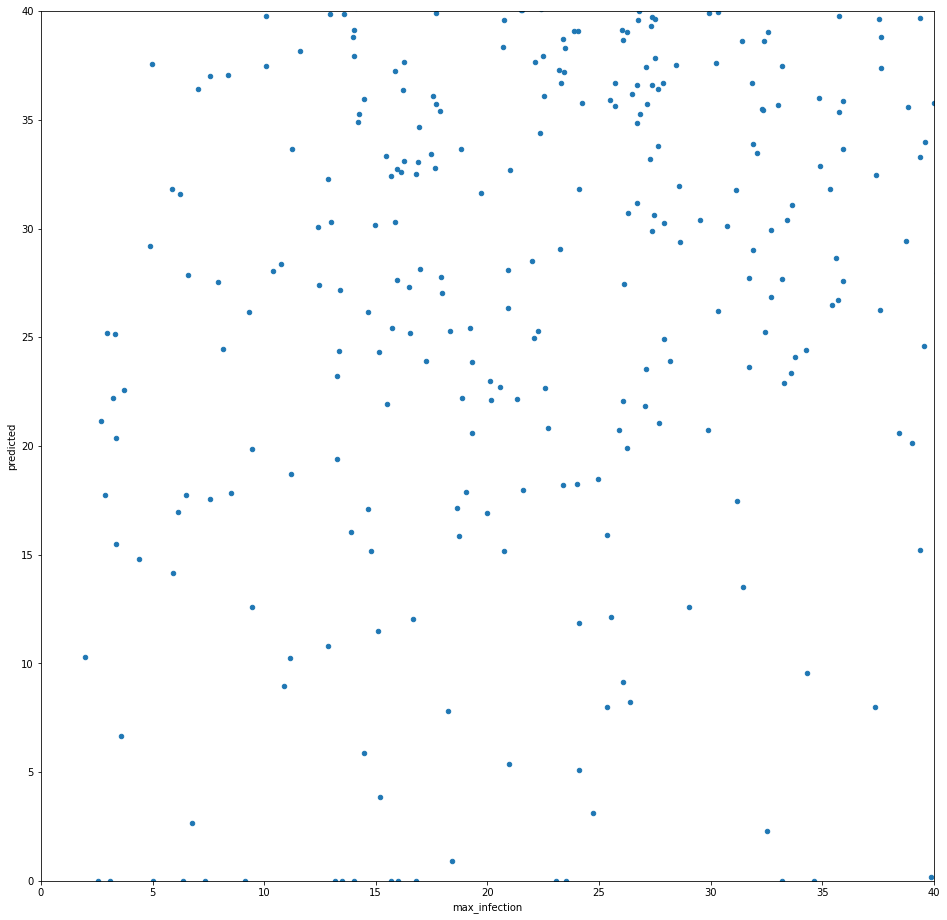

In [30]:
county_details = county_details_raw.copy()
#whole_data = county_details.query('median_infection > 0')[]
x_columns = ['adjusted_density', 'longitude', 'latitude', 'conservative', 'median_age', 'white', 'hispanic', 'black', 'asian', 'median_income', 'poverty_percent', 'obesity', 'diabetes', 'tots', 'kids', 'teens']
y_columns = ['max_infection']

whole_data = county_details.query('mean_infection > 0')[x_columns + y_columns].dropna()
#print(county_details['median_infection'].min())
X = whole_data[x_columns].copy()
Y = whole_data[y_columns].copy()

# Group 2: Multiplying for clarity of interpretation
X['hispanic'] = X['hispanic'] * 100
X['black'] = X['black'] * 100
X['asian'] = X['asian'] * 100
X['white'] = X['white'] * 100
X['tots'] = X['tots'] * 100
X['teens'] = X['teens'] * 100
X['kids'] = X['kids'] * 100
X['conservative'] = X['conservative'] * 100

X_imputed = MinMaxScaler().fit_transform(X) * 100

polynomial_features = PolynomialFeatures(degree=1)
X_poly = polynomial_features.fit_transform(X)
X_poly = sm.add_constant(X_poly)

#X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.33, random_state=42)

model = sm.OLS(Y, X_poly).fit()
predictions = model.predict(X_poly) 

Y_pred = Y.copy()
Y_pred['predicted'] = predictions
Y_pred['predicted'] = Y_pred['predicted'].apply(lambda x:x if x >=0 else 0).fillna(0)
Y_pred.plot.scatter(x=y_columns[0], y='predicted', figsize=(16,16), ylim=(0,40), xlim=(0,40));
print('R-Squared Adj: ' + str(model.rsquared_adj));
plt.plot();

In [31]:
county_name = 'Suffolk County'
state_name = 'New York'

specific_fips = [48039, 48201, 31153, 36103, 18169 ,42055, 12003, 40093, 1001, 26065]
random_fips = [county_details.iloc[random.randrange(0, len(county_details.index))].name for i in range(20)]

for fips in (specific_fips + random_fips):
    interested_county_details = county_details.loc[fips];
    county_name = interested_county_details['county']
    state_name = interested_county_details['st']

    interested_county = county_percentages.loc[fips]

    peak_info = county_details.loc[fips]['peak_info']
    raw_peak_info = county_details.loc[fips]['peak_info_raw']
    #print(peak_info)
    peaks = [a[0] for a in peak_info]

    ax = interested_county.plot.line(figsize=(16,10))

    interested_county.iloc[peaks].rename('values').reset_index().plot.scatter(
        x='date', 
        y='values', 
        ax = ax, 
        color='red', 
        s=50, 
        title='{0}, {1} ({2})'.format(county_name, state_name, fips), 
    )
    
    plt.show()



NameError: name 'county_percentages' is not defined

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

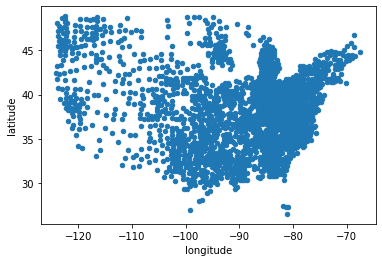

In [32]:
(
    county_details
    .loc[Y_pred[(Y_pred['predicted'] > Y_pred[y_columns[0]]) & ((Y_pred.index.astype(float) / 1000).astype(int) != 15)].index].plot.scatter(x='longitude', y='latitude')
)


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

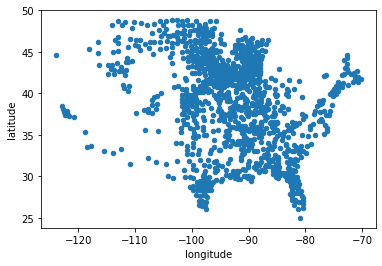

In [33]:
(
    county_details
    .loc[Y_pred[(Y_pred['predicted'] < Y_pred[y_columns[0]]) & ((Y_pred.index.astype(float) / 1000).astype(int) != 15)].index].plot.scatter(x='longitude', y='latitude')
)


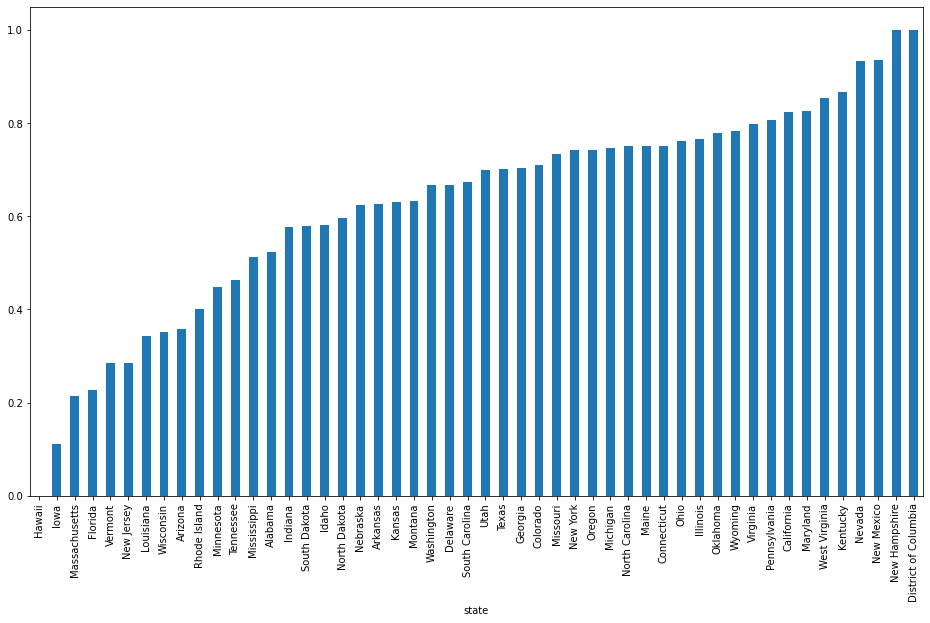

In [321]:
grouped = Y_pred[Y_pred['predicted'] > Y_pred['max_infection']].groupby('st').count().div(Y_pred.groupby('st').count()).fillna(0).iloc[:,0]


#Y_pred.groupby('st').count()

#Y_pred.groupby('state')['predicted_above_reported'].median().sort_values()
(
    Y_pred[['st', 'state']]
    .set_index('st')
    .drop_duplicates()
    .assign(
        predicted_above_reported=lambda x:grouped, 
        count=lambda x:Y_pred.groupby('st').count().iloc[:,0]
    )
    .sort_values(by='predicted_above_reported')
    .set_index('state')
    ['predicted_above_reported']
    .plot.bar(x='index', figsize=(16,9))
)




In [370]:
interested_county = county_percentages_raw.loc[48039]
peaks, heights = find_peaks(interested_county, height=10, prominence=10)
len(tuple(peaks))

1

fips
48041    48041 ha
48039    48039 ha
Name: fips, dtype: object

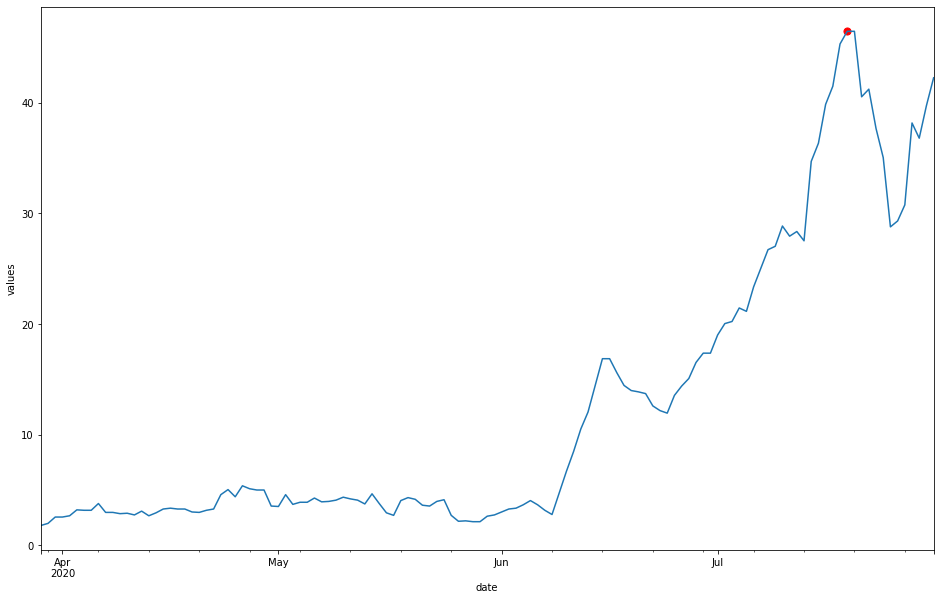

In [371]:
ax = interested_county.plot.line(figsize=(16,10))

interested_county.iloc[peaks].rename('values').reset_index().plot.scatter(x='date', y='values', ax = ax, color='red', s=50)

county_details.loc[[48041, 48039]].index.to_series().apply(lambda x:str(x) + ' ha')

In [270]:
means = (
    df
    .dropna()
    .query('YEAR==12 & AGEGRP > 0')
    .assign(fips=lambda x:x['STATE'].astype(int)*1000+x['COUNTY'].astype(int))
    [['fips', 'AGEGRP', 'TOT_POP']]
    .assign(
        AGEGRP2=lambda x:x['AGEGRP'] * 5 - 2.5, 
        SUMAGE=lambda x:x['AGEGRP2'] * x['TOT_POP']
    )
)

In [277]:
def median_from_frequency(df):
    total_pop = df['TOT_POP'].sum()
    median = total_pop / 2
    cumsum = df['TOT_POP'].cumsum()
    above = cumsum[cumsum > median][:1]
    below = cumsum[cumsum <= median][-1:]
    startage = (df[cumsum <= median][-1:]['AGEGRP'] * 5).iloc[0]
    return startage + (median - below.iloc[0]) / (above.iloc[0] - below.iloc[0]) * 5

means.groupby('fips').apply(median_from_frequency).sort_values()

fips
16065    23.309476
46121    23.644958
2158     23.708882
51678    23.734971
51750    24.683106
           ...    
35021    59.550000
12015    60.118506
35003    61.824866
15005    63.000000
12119    67.858652
Length: 3142, dtype: float64

In [1682]:
county_details.loc[48039]
        

st                                                              Texas
county                                                Brazoria County
area                                                           1357.7
pop                                                            374264
density                                                        275.66
longitude                                                    -95.4458
latitude                                                      29.1884
conservative                                                 0.627557
median_age                                                       36.1
mean_age                                                      36.8205
hispanic                                                     0.315689
black                                                        0.151262
asian                                                        0.069467
max_height                                                    46.4531
peak_info_raw       

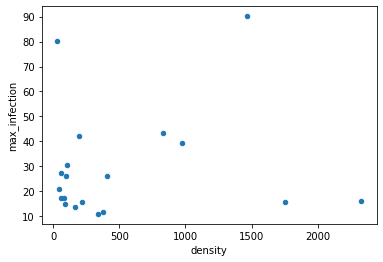

In [1684]:
county_details.query('(adjusted_density > 609) & (adjusted_density < 709) & peak_count == 1').plot.scatter(x='density', y='max_infection')


In [1688]:
counties_like_brazoria = county_details.query('(adjusted_density > 609) & (adjusted_density < 709)')



In [1689]:
print(counties_like_brazoria['max_infection'].median())
counties_like_brazoria.sort_values(by='max_infection', ascending=False)



16.058779031239588


,st,county,area,pop,density,longitude,latitude,conservative,median_age,mean_age,...,asian,max_height,peak_info_raw,peak_info,peak_count,peak_date,median_infection,mean_infection,max_infection,adjusted_density
fips,,,,,,,,,,,,,,,,,,,,,
22051,Louisiana,Jefferson Parish,295.632,432493.0,1462.943795,-90.135227,29.827561,0.576775,39.6,40.442394,...,0.042697,90.141839,"([9, 39, 78, 109], {'peak_heights': [90.141838...","[(9, 90.14183879441813)]",1,2020-04-07,16.796308,23.434688,90.141839,663.519334
51175,Virginia,Southampton County,599.145,17631.0,29.426933,-77.102646,36.723332,0.583430,47.4,44.167801,...,0.005105,80.215854,"([28, 111], {'peak_heights': [80.2158535696054...","[(28, 80.21585356960547)]",1,2020-04-26,4.051306,9.687596,80.215854,650.292127
6099,California,Stanislaus County,1494.827,550660.0,368.377076,-120.997492,37.558041,0.490156,34.4,36.551284,...,0.061424,65.194494,"([108], {'peak_heights': [65.19449388007119]})",[],0,NaT,2.633204,9.459371,65.194494,627.304860
12099,Florida,Palm Beach County,1969.763,1496770.0,759.873142,-80.465018,26.647331,0.420974,45.2,44.349362,...,0.029446,49.611592,"([81, 111], {'peak_heights': [18.7737594954468...",[],0,NaT,6.781269,14.179238,49.611592,645.956575
12115,Florida,Sarasota County,555.868,433742.0,780.296761,-82.331502,27.184592,0.559755,57.1,51.479128,...,0.018387,46.900824,"([111], {'peak_heights': [46.9008238603989]})",[],0,NaT,2.486666,7.749199,46.900824,642.538548
51139,Virginia,Page County,310.856,23902.0,76.890908,-78.481092,38.621787,0.756984,45.8,43.619572,...,0.005062,46.618932,"([32, 65, 100], {'peak_heights': [46.618932067...","[(32, 46.618932067848476), (65, 18.52803710388...",3,2020-07-07,9.562858,11.445021,46.618932,662.694779
48039,Texas,Brazoria County,1357.701,374264.0,275.660105,-95.445825,29.188391,0.627557,36.1,36.820493,...,0.069467,46.453077,"([78, 112], {'peak_heights': [16.8664365260885...",[],0,NaT,4.103291,10.089309,46.453077,659.579960
48141,Texas,El Paso County,1012.693,839238.0,828.719069,-106.235906,31.772824,0.272981,32.7,35.656512,...,0.013597,43.525879,"([73, 105], {'peak_heights': [12.0857934731949...","[(105, 43.52587874783009)]",1,2020-07-12,7.447232,11.358615,43.525879,659.629818
48139,Texas,Ellis County,935.487,184826.0,197.571960,-96.796901,32.347956,0.734402,36.4,37.178508,...,0.008489,42.279147,"([107], {'peak_heights': [42.2791474916176]})","[(107, 42.2791474916176)]",1,2020-07-14,3.400882,8.950368,42.279147,686.228931


In [1677]:

origin = (county_details.loc[48039]['latitude'], county_details.loc[48039]['longitude'])


#distance(county_details, 48039)
#county_details[['latitude', 'longitude']].dropna().apply(distance, axis=1).to_frame(name='miles').query('miles > 0 & miles < 100')


In [349]:
(1-((county_percentages_raw.loc[48039][-21:].sum() * 7) / 100000)) ** 25


0.27550772043691224

0.38814430081286716

In [1619]:
(
    pd.concat([county_details[['st', 'county', 'density']], county_percentages.loc[counties_like_brazoria.index].T.describe().T], axis=1)
    .dropna()
    .sort_values(by='max', ascending=False)
)

,st,county,density,count,mean,std,min,25%,50%,75%,max
fips,,,,,,,,,,,
13095,Georgia,Dougherty County,267.596421,118.0,21.458561,22.349015,0.974513,5.562846,10.719646,27.733022,83.320881
19013,Iowa,Black Hawk County,231.946254,118.0,17.588559,17.612727,0.108862,5.633597,11.430487,24.058454,78.380485
12097,Florida,Osceola County,283.061623,118.0,14.464012,21.307437,0.950477,1.976993,3.231623,14.399734,73.604975
48245,Texas,Jefferson County,287.077982,118.0,15.068384,19.205219,0.681448,3.137502,4.287446,23.708726,73.142130
48309,Texas,McLennan County,247.442631,118.0,11.443096,18.940213,0.111336,0.445345,0.890690,13.610850,67.636739
12005,Florida,Bay County,230.342049,118.0,10.560174,18.708134,0.000000,0.756377,1.430984,6.582525,65.988789
45051,South Carolina,Horry County,312.269379,118.0,16.572589,20.282960,0.645534,1.422193,3.086461,34.525998,63.141323
46099,South Dakota,Minnehaha County,239.279834,118.0,17.014495,17.659046,1.479358,5.122276,7.655677,25.574398,61.985091
13185,Georgia,Lowndes County,236.674152,118.0,16.747208,17.312602,1.338457,3.163625,6.023056,29.081016,61.447334


In [1707]:
pd.set_option('display.max_columns', 500)

In [1717]:
pd.read_csv("co-est2019-alldata.csv", encoding = "ISO-8859-1").query('SUMLEV == 50').query('CTYNAME=="Fairfax city"')

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,DEATHS2014,DEATHS2015,DEATHS2016,DEATHS2017,DEATHS2018,DEATHS2019,NATURALINC2010,NATURALINC2011,NATURALINC2012,NATURALINC2013,NATURALINC2014,NATURALINC2015,NATURALINC2016,NATURALINC2017,NATURALINC2018,NATURALINC2019,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,INTERNATIONALMIG2013,INTERNATIONALMIG2014,INTERNATIONALMIG2015,INTERNATIONALMIG2016,INTERNATIONALMIG2017,INTERNATIONALMIG2018,INTERNATIONALMIG2019,DOMESTICMIG2010,DOMESTICMIG2011,DOMESTICMIG2012,DOMESTICMIG2013,DOMESTICMIG2014,DOMESTICMIG2015,DOMESTICMIG2016,DOMESTICMIG2017,DOMESTICMIG2018,DOMESTICMIG2019,NETMIG2010,NETMIG2011,NETMIG2012,NETMIG2013,NETMIG2014,NETMIG2015,NETMIG2016,NETMIG2017,NETMIG2018,NETMIG2019,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RESIDUAL2019,GQESTIMATESBASE2010,GQESTIMATES2010,GQESTIMATES2011,GQESTIMATES2012,GQESTIMATES2013,GQESTIMATES2014,GQESTIMATES2015,GQESTIMATES2016,GQESTIMATES2017,GQESTIMATES2018,GQESTIMATES2019,RBIRTH2011,RBIRTH2012,RBIRTH2013,RBIRTH2014,RBIRTH2015,RBIRTH2016,RBIRTH2017,RBIRTH2018,RBIRTH2019,RDEATH2011,RDEATH2012,RDEATH2013,RDEATH2014,RDEATH2015,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
2971,50,3,5,51,600,Virginia,Fairfax city,22565,22554,22614,22460,22894,23230,23310,23230,23246,23435,23725,24019,60,-154,434,336,80,-80,16,189,290,294,77,216,337,270,272,238,305,556,631,673,34,186,188,171,159,226,246,229,214,203,43,30,149,99,113,12,59,327,417,470,25,141,228,206,291,274,263,251,137,140,-7,-327,54,34,-334,-371,-307,-390,-264,-315,18,-186,282,240,-43,-97,-44,-139,-127,-175,-1,2,3,-3,10,5,1,1,0,-1,521,521,521,521,521,521,521,521,521,521,521,9.584239,14.860872,11.707571,11.68887,10.227761,13.125054,23.821255,26.759966,28.192024,8.253095,8.290338,7.414795,6.832832,9.712076,10.586109,9.811272,9.075488,8.503686,1.331144,6.570534,4.292776,4.856038,0.515685,2.538945,14.009983,17.684478,19.688338,6.256378,10.05424,8.932443,12.505372,11.774817,11.317669,10.75384,5.810008,5.864611,-14.509473,2.381267,1.474287,-14.353245,-15.943275,-13.21112,-16.709154,-11.195929,-13.195375,-8.253095,12.435507,10.40673,-1.847873,-4.168457,-1.89345,-5.955314,-5.38592,-7.330764


In [1721]:
pd.read_csv("co-est2019-alldata.csv", encoding = "ISO-8859-1").query('SUMLEV == 50').query('CTYNAME=="Brazoria County"')

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,DEATHS2014,DEATHS2015,DEATHS2016,DEATHS2017,DEATHS2018,DEATHS2019,NATURALINC2010,NATURALINC2011,NATURALINC2012,NATURALINC2013,NATURALINC2014,NATURALINC2015,NATURALINC2016,NATURALINC2017,NATURALINC2018,NATURALINC2019,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,INTERNATIONALMIG2013,INTERNATIONALMIG2014,INTERNATIONALMIG2015,INTERNATIONALMIG2016,INTERNATIONALMIG2017,INTERNATIONALMIG2018,INTERNATIONALMIG2019,DOMESTICMIG2010,DOMESTICMIG2011,DOMESTICMIG2012,DOMESTICMIG2013,DOMESTICMIG2014,DOMESTICMIG2015,DOMESTICMIG2016,DOMESTICMIG2017,DOMESTICMIG2018,DOMESTICMIG2019,NETMIG2010,NETMIG2011,NETMIG2012,NETMIG2013,NETMIG2014,NETMIG2015,NETMIG2016,NETMIG2017,NETMIG2018,NETMIG2019,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RESIDUAL2019,GQESTIMATESBASE2010,GQESTIMATES2010,GQESTIMATES2011,GQESTIMATES2012,GQESTIMATES2013,GQESTIMATES2014,GQESTIMATES2015,GQESTIMATES2016,GQESTIMATES2017,GQESTIMATES2018,GQESTIMATES2019,RBIRTH2011,RBIRTH2012,RBIRTH2013,RBIRTH2014,RBIRTH2015,RBIRTH2016,RBIRTH2017,RBIRTH2018,RBIRTH2019,RDEATH2011,RDEATH2012,RDEATH2013,RDEATH2014,RDEATH2015,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
2586,50,3,7,48,39,Texas,Brazoria County,313166,313117,314428,319147,324224,329890,337570,345227,353155,361853,368887,374264,1311,4719,5077,5666,7680,7657,7928,8698,7034,5377,1203,4699,4502,4551,4762,4882,4877,4683,4728,4681,507,1970,1956,2135,2247,2149,2307,2330,2507,2498,696,2729,2546,2416,2515,2733,2570,2353,2221,2183,82,306,434,424,648,495,476,415,316,171,517,1683,2101,2793,4433,4399,4870,5911,4496,3025,599,1989,2535,3217,5081,4894,5346,6326,4812,3196,16,1,-4,33,84,30,12,19,1,-2,10559,10587,10670,10558,10270,10577,10294,9957,10451,10475,10474,14.833287,13.995036,13.915006,14.26902,14.300004,13.966568,13.099154,12.940307,12.597709,6.21868,6.080473,6.527914,6.732988,6.294697,6.606699,6.51741,6.861538,6.722725,8.614608,7.914563,7.387092,7.536032,8.005308,7.359869,6.581745,6.078769,5.874984,0.965947,1.349144,1.29641,1.941689,1.449918,1.363151,1.160826,0.864877,0.460203,5.31271,6.531224,8.539796,13.283193,12.885235,13.946522,16.534081,12.305334,8.14101,6.278657,7.880368,9.836206,15.224882,14.335154,15.309673,17.694907,13.170211,8.601213


In [1727]:
len(pd.read_csv("co-est2019-alldata.csv", encoding = "ISO-8859-1").query('SUMLEV == 50 & COUNTY % 2 == 1'))


3074

In [1844]:
daily_report_data_raw = get_daily_report_data()

In [1934]:
daily_report_data = daily_report_data_raw.copy()
# 51 confirmed
# 207 per 100000

daily_report_data['Tests'] = daily_report_data['Confirmed'].div(daily_report_data['Incidence_Rate']) * 100000

#daily_report_data.plot.scatter(x='Incidence_Rate', y='Tests', figsize=(16,10))

#daily_report_data.query('Tests > 1000000')

starter = (
    daily_report_data
    [['Tests', 'FIPS', 'date']]                           # Keep these three columns
    .rename(columns={'Tests':'tests', 'FIPS':'fips'}) # Rename for simplicity
    .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
    .pivot(values='tests', index='date', columns='fips')  # Create the pivot table.                                               # Fill NA values here.
)


(
    county_details
    .query('median_infection != 0')
    .assign(
        median_infection_log=lambda x:np.log(x['median_infection']),
        tests_performed_log=lambda x:np.log(x['tests_performed'])
    )
    .query('abs(tests_performed_log - (median_infection_log * -1 + 9.56)) < 0.01')
    
)#.groupby('st').count()

#.plot.scatter(x='median_infection_log', y='tests_performed_log', figsize=(16, 10))
#county_details.tests_performed.apply(lambda x:np.log(x)).plot.hist(bins=100, figsize=(16,10))
#county_details.query('median_infection != 0')['median_infection'].apply(lambda x:np.log(x)).plot.hist(bins=100, figsize=(16,10))

,county,area,pop,density,longitude,latitude,conservative,median_age,mean_age,hispanic,black,asian,median_income,adjusted_density,max_height,peak_info_raw,peak_info,peak_count,peak_date,median_infection,mean_infection,max_infection,tests_performed,median_infection_log,tests_performed_log
st,,,,,,,,,,,,,,,,,,,,,,,,,
Arkansas,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
California,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Colorado,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Georgia,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Idaho,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Illinois,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Indiana,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Iowa,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Kansas,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [33]:
chsi = 

In [126]:

result

,obesity,diabetes
fips,,
1001,24.500000,14.2
1003,23.600000,7.2
1005,25.600000,6.6
1007,26.897561,13.1
1009,24.200000,8.4
...,...,...
56037,23.600000,5.3
56039,9.000000,2.4
56041,22.700000,4.8


In [54]:
county_details.loc[1007]

st                                                            Alabama
county                                                    Bibb County
area                                                          622.582
pop                                                             22394
density                                                       35.9696
longitude                                                     -87.125
latitude                                                      32.9965
conservative                                                 0.782397
median_age                                                         40
mean_age                                                      40.5307
hispanic                                                      0.02782
black                                                        0.212691
asian                                                      0.00214343
white                                                        0.767661
median_income       

In [63]:
bhrf = pd.read_sas('/Users/davidmorton/Downloads/LLCP2018.XPT')

In [78]:
pd.set_option('display.max_columns', 500)

In [139]:
get_all_census_data()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,UNDER5_MALE,UNDER5_FEM,AGE513_TOT,AGE513_MALE,AGE513_FEM,AGE1417_TOT,AGE1417_MALE,AGE1417_FEM,AGE1824_TOT,AGE1824_MALE,AGE1824_FEM,AGE16PLUS_TOT,AGE16PLUS_MALE,AGE16PLUS_FEM,AGE18PLUS_TOT,AGE18PLUS_MALE,AGE18PLUS_FEM,AGE1544_TOT,AGE1544_MALE,AGE1544_FEM,AGE2544_TOT,AGE2544_MALE,AGE2544_FEM,AGE4564_TOT,AGE4564_MALE,AGE4564_FEM,AGE65PLUS_TOT,AGE65PLUS_MALE,AGE65PLUS_FEM,AGE04_TOT,AGE04_MALE,AGE04_FEM,AGE59_TOT,AGE59_MALE,AGE59_FEM,AGE1014_TOT,AGE1014_MALE,AGE1014_FEM,AGE1519_TOT,AGE1519_MALE,AGE1519_FEM,AGE2024_TOT,AGE2024_MALE,AGE2024_FEM,AGE2529_TOT,AGE2529_MALE,AGE2529_FEM,AGE3034_TOT,AGE3034_MALE,AGE3034_FEM,AGE3539_TOT,AGE3539_MALE,AGE3539_FEM,AGE4044_TOT,AGE4044_MALE,AGE4044_FEM,AGE4549_TOT,AGE4549_MALE,AGE4549_FEM,AGE5054_TOT,AGE5054_MALE,AGE5054_FEM,AGE5559_TOT,AGE5559_MALE,AGE5559_FEM,AGE6064_TOT,AGE6064_MALE,AGE6064_FEM,AGE6569_TOT,AGE6569_MALE,AGE6569_FEM,AGE7074_TOT,AGE7074_MALE,AGE7074_FEM,AGE7579_TOT,AGE7579_MALE,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,50,1,1,Alabama,Autauga County,1,54571,26569,28002,3579,1866,1713,7418,3747,3671,3616,1842,1774,4617,2335,2282,41804,20046,21758,39958,19114,20844,22100,10867,11233,14730,7115,7615,14065,6843,7222,6546,2821,3725,3579,1866,1713,3991,2001,1990,4290,2171,2119,4290,2213,2077,3080,1539,1541,3157,1543,1614,3330,1594,1736,4157,2004,2153,4086,1974,2112,4332,2174,2158,3873,1866,2007,3083,1524,1559,2777,1279,1498,2277,1014,1263,1736,807,929,1251,546,705,731,295,436,551,159,392,37.0,35.9,37.9
1,50,1,1,Alabama,Autauga County,2,54597,26584,28013,3584,1869,1715,7425,3752,3673,3618,1843,1775,4617,2335,2282,41817,20052,21765,39970,19120,20850,22116,10874,11242,14744,7121,7623,14067,6845,7222,6542,2819,3723,3584,1869,1715,3994,2004,1990,4294,2173,2121,4292,2214,2078,3080,1539,1541,3162,1546,1616,3333,1595,1738,4160,2006,2154,4089,1974,2115,4334,2176,2158,3873,1866,2007,3083,1524,1559,2777,1279,1498,2277,1014,1263,1734,806,928,1250,546,704,730,294,436,551,159,392,37.0,35.9,37.8
2,50,1,1,Alabama,Autauga County,3,54773,26672,28101,3575,1863,1712,7400,3720,3680,3566,1820,1746,4671,2362,2309,42050,20194,21856,40232,19269,20963,22205,10944,11261,14824,7189,7635,14138,6871,7267,6599,2847,3752,3575,1863,1712,3964,1984,1980,4292,2163,2129,4229,2182,2047,3152,1573,1579,3191,1574,1617,3372,1615,1757,4143,2002,2141,4118,1998,2120,4321,2162,2159,3908,1884,2024,3119,1533,1586,2790,1292,1498,2289,1018,1271,1752,814,938,1259,552,707,743,299,444,556,164,392,37.1,36.0,37.9
3,50,1,1,Alabama,Autauga County,4,55227,26981,28246,3551,1852,1699,7355,3683,3672,3477,1782,1695,4816,2487,2329,42613,20573,22040,40844,19664,21180,22260,11055,11205,14832,7242,7590,14335,6979,7356,6861,2956,3905,3551,1852,1699,3902,1938,1964,4318,2201,2117,4030,2071,1959,3398,1742,1656,3216,1608,1608,3446,1665,1781,4003,1939,2064,4167,2030,2137,4196,2073,2123,4035,1985,2050,3247,1582,1665,2857,1339,1518,2323,1021,1302,1843,844,999,1312,585,727,782,315,467,601,191,410,37.3,36.2,38.4
4,50,1,1,Alabama,Autauga County,5,54954,26826,28128,3402,1791,1611,7255,3658,3597,3511,1801,1710,4802,2488,2314,42544,20473,22071,40786,19576,21210,21955,10865,11090,14539,7029,7510,14254,6952,7302,7191,3107,4084,3402,1791,1611,3794,1913,1881,4358,2198,2160,4050,2119,1931,3366,1717,1649,3203,1576,1627,3328,1599,1729,3822,1826,1996,4186,2028,2158,4081,1999,2082,4121,2082,2039,3273,1545,1728,2779,1326,1453,2459,1090,1369,1907,863,1044,1359,608,751,834,340,494,632,206,426,37.7,36.4,38.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,50,